In [172]:
import numpy as np
import numpy.polynomial as pol
from itertools import chain
import matplotlib.pyplot as plt

#LU decomposition subroutine
def getL(LU):
    dim = LU.shape[0]
    L = LU.copy()
    for i in range(dim):
            L[i, i] = 1
            L[i, i+1:] = 0
    return L

def getU(LU):
    dim = LU.shape[0]
    U = LU.copy()
    for i in range(1, dim):
        U[i, :i] = 0
    return U

def getLU(a, pres):
    dim = a.shape[0]
    a = a.copy()
    detSight = 1
    P = np.matrix(np.zeros(shape=(dim, dim)))
    Q = np.matrix(np.zeros(shape=(dim, dim)))
    np.fill_diagonal(P, 1)
    np.fill_diagonal(Q, 1)
    for i in range(dim - 1):
        (choseRow, choseCol) = np.unravel_index(np.argmax(np.abs(a[i:, i:])), a[i:, i:].shape)
        choseRow += i
        choseCol += i
        if choseRow != i:
            detSight *= -1
            a[[choseRow, i]] = a[[i, choseRow]]
            P[:, [choseRow, i]] = P[:, [i, choseRow]]
        if choseCol != i:
            detSight *= -1
            a[:, [choseCol, i]] = a[:, [i, choseCol]]
            Q[[choseCol, i]] = Q[[i, choseCol]]
        if np.abs(a[i, i]) < pres:
            return P, getL(a), getU(a), Q, detSight
        for j in range(i + 1, dim):
            coef = a[j, i] / a[i, i]
            a[j, i:] = a[j, i:] - a[i, i:]*coef
            a[j, i] = coef
    return P, getL(a), getU(a), Q, detSight

#solving
def directSub(L, B, P):
    dim = P.shape[0]
    B = P.transpose()*B
    Y = np.matrix(np.zeros(shape=(dim, 1)))
    for i in range(dim):
        summ = 0
        for j in range(i):
            summ += L[i, j]*Y[j, 0]
        Y[i, 0] = B[i, 0] - summ
    return Y

def inverceSub(U, Y, P, Q):
    dim = P.shape[0]
    X = np.matrix(np.zeros(shape=(dim, 1)))
    for i in range(dim):
        summ = 0
        for j in range(i):
            summ += U[dim - 1 - i, dim - 1 - j] * X[dim - 1 - j, 0]
        X[dim - 1 - i, 0] = (Y[dim - 1 - i, 0] - summ) / U[dim - 1 - i, dim - 1 - i]
    return (X.transpose()*Q).transpose()

def solve(a, b, pres):
    P, L, U, Q, Det = getLU(a, pres)
    Y = directSub(L, b, P)
    X = inverceSub(U, Y, P, Q)
    return X

functions = [
    lambda x: x - np.sin(x)
]

def get_values(x, func):
    y = []
    for x_ in x:
        y.append(func(x_))
    return y

def get_apr_values(x, func):
    y = []
    for x_ in x:
        y_ = func(x_)
        err = (1 - np.random.random()*2)*y_/10
        y.append(y_ + err)
    return y

def get_mult_apr_values(x, func, count):
    y = []
    for x_ in x:
        vals = []
        for i in range(count):
            y_ = func(x_)
            err = (1 - np.random.random()*2)*y_/10
            vals.append(y_+err)
        y.append(sum(vals)/len(vals))
    return y

def get_equal_range(a, b, n):
    range_ = []
    adder = (b-a)/(n-1)
    for i in range(n):
        range_.append(a+adder*i)
    return range_

def get_optimal_range(a, b, n):
    range_ = []
    for i in range(n):
        range_.append(((b-a)*np.cos((2*i+1)*np.pi/(2*n))+(b+a))/2)
    return range_[::-1]

def get_legender_basis(n):
    basis = [
        pol.Polynomial([1]),
        pol.Polynomial([0, 1]),
    ]
    for i in range(1, n-1):
        basis.append(((2*i + 1)*basis[1]*basis[i] - i*basis[i-1])/(i+1))
    return basis

class PolynomialApproximation3:
    def __init__(self, x, y):
        self.x = np.matrix(x).transpose()
        self.y = np.matrix(y).transpose()
        phi = np.matrix([
            pol.Polynomial([1]),
            pol.Polynomial([0, 1]),
            pol.Polynomial([0, 0, 1]),
            pol.Polynomial([0, 0, 0, 1])
        ]).transpose()
        Q = np.matrix([
            phi[0, 0](np.array(self.x.transpose()[0])[0]),
            phi[1, 0](np.array(self.x.transpose()[0])[0]),
            phi[2, 0](np.array(self.x.transpose()[0])[0]),
            phi[3, 0](np.array(self.x.transpose()[0])[0])
        ]).transpose()
        H = Q.transpose()*Q
        b = Q.transpose()*self.y
        a = solve(H, b, 10**(-12))
        self.P = (a.transpose()*phi)[0, 0]
        # print('\n')
        # print('x: ', self.x)
        # print('y: ', self.y)
        # print('phi: ', phi)
        # print('Q: ', Q)
        # print('H: ', H)
        # print('b: ', b)
        # print('a: ', a)
        # print('P: ', self.P)
    def calculate(self, x):
        return self.P(x)
    def calculate_range(self, x):
        y = []
        for x_ in x:
            y.append(self.calculate(x_))
        return y

class LegendrePolynomial:
    def __init__(self, x, y):
        basis = get_legender_basis(4)
        c = []
        for i in range(4):
            c.append(sum(np.array(get_values(x, basis[i]))*np.array(y))/sum(np.array(get_values(x, basis[i]**2))))
        self.Polynomial = (np.matrix(c)*np.matrix(basis).transpose())[0, 0]
        # print(c)
        # print(self.Polynomial)
    def calculate(self, x):
        return self.Polynomial(x)
    def calculate_range(self, x):
        y = []
        for x_ in x:
            y.append(self.calculate(x_))
        return y

class LagrangePolynomial:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def calculate(self, x):
        res = 0
        for i in range(len(self.y)):
            y_ = self.y[i]
            x_ = self.x[i]
            l = 1
            for j in chain(range(0,i), range(i+1,len(self.x))):
                l = l*(x - self.x[j])/(x_ - self.x[j])
            res += y_*l
        return res
    def calculate_range(self, x):
        y = []
        for x_ in x:
            y.append(self.calculate(x_))
        return y

def test(func, a, b, start_n, end_n, plot_n):
    for n in range(start_n, end_n+1):
        fig, axs = plt.subplots(1, 2, figsize=(18, 9))
        plot_range = get_equal_range(a, b, plot_n)
        plot_values = get_values(plot_range, func)
        axs[0].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[1].plot(plot_range, plot_values, linewidth=2.0, color='g')

        eq_range = get_equal_range(a, b, n)
        eq_values = get_values(eq_range, func)
        eq_pol = PolynomialApproximation3(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[0].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[0].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[0].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_values(opt_range, func)
        opt_pol = PolynomialApproximation3(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[1].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[1].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[1].grid(True)

def test2(func, a, b, start_n, end_n, plot_n):
    for n in range(start_n, end_n+1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        plot_range = get_equal_range(a, b, plot_n)
        plot_values = get_values(plot_range, func)
        axs[0].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[1].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[2].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[3].plot(plot_range, plot_values, linewidth=2.0, color='g')

        eq_range = get_equal_range(a, b, n)
        eq_values = get_apr_values(eq_range, func)
        eq_pol = PolynomialApproximation3(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[0].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[0].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[0].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_apr_values(opt_range, func)
        opt_pol = PolynomialApproximation3(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[1].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[1].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[1].grid(True)

        eq_range = get_equal_range(a, b, n)
        eq_values = get_apr_values(eq_range, func)
        eq_pol = LagrangePolynomial(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[2].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[2].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[2].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_apr_values(opt_range, func)
        opt_pol = LagrangePolynomial(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[3].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[3].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[3].grid(True)

def test3(func, a, b, start_n, end_n, plot_n, count):
    for n in range(start_n, end_n+1):
        fig, axs = plt.subplots(1, 2, figsize=(18, 9))
        plot_range = get_equal_range(a, b, plot_n)
        plot_values = get_values(plot_range, func)
        axs[0].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[1].plot(plot_range, plot_values, linewidth=2.0, color='g')

        eq_range = get_equal_range(a, b, n)
        eq_values = get_mult_apr_values(eq_range, func, count)
        eq_pol = PolynomialApproximation3(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[0].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[0].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[0].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_mult_apr_values(opt_range, func, count)
        opt_pol = PolynomialApproximation3(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[1].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[1].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[1].grid(True)

def test4_1(func, a, b, start_n, end_n, plot_n):
    for n in range(start_n, end_n+1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        plot_range = get_equal_range(a, b, plot_n)
        plot_values = get_values(plot_range, func)
        axs[0].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[1].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[2].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[3].plot(plot_range, plot_values, linewidth=2.0, color='g')

        eq_range = get_equal_range(a, b, n)
        eq_values = get_values(eq_range, func)
        eq_pol = LegendrePolynomial(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[0].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[0].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[0].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_values(opt_range, func)
        opt_pol = LegendrePolynomial(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[1].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[1].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[1].grid(True)

        eq_range = get_equal_range(a, b, n)
        eq_values = get_values(eq_range, func)
        eq_pol = PolynomialApproximation3(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[2].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[2].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[2].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_values(opt_range, func)
        opt_pol = PolynomialApproximation3(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[3].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[3].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[3].grid(True)

def test4_2(func, a, b, start_n, end_n, plot_n):
    for n in range(start_n, end_n+1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        plot_range = get_equal_range(a, b, plot_n)
        plot_values = get_values(plot_range, func)
        axs[0].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[1].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[2].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[3].plot(plot_range, plot_values, linewidth=2.0, color='g')

        eq_range = get_equal_range(a, b, n)
        eq_values = get_apr_values(eq_range, func)
        eq_pol = LegendrePolynomial(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[0].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[0].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[0].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_apr_values(opt_range, func)
        opt_pol = LegendrePolynomial(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[1].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[1].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[1].grid(True)

        eq_range = get_equal_range(a, b, n)
        eq_values = get_apr_values(eq_range, func)
        eq_pol = PolynomialApproximation3(eq_range, eq_values)
        eq_pol_values = eq_pol.calculate_range(plot_range)
        axs[2].plot(plot_range, eq_pol_values, linewidth=2.0, color='r')
        axs[2].set_title(f'eq, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(eq_pol_values)).transpose(), np.inf), 5)}')
        axs[2].grid(True)

        opt_range = get_optimal_range(a, b, n)
        opt_values = get_apr_values(opt_range, func)
        opt_pol = PolynomialApproximation3(opt_range, opt_values)
        opt_pol_values = opt_pol.calculate_range(plot_range)
        axs[3].plot(plot_range, opt_pol_values, linewidth=2.0, color='r')
        axs[3].set_title(f'opt, pnt: {n}, err: {np.around(np.linalg.norm((np.matrix(plot_values) - np.matrix(opt_pol_values)).transpose(), np.inf), 5)}')
        axs[3].grid(True)

First test:


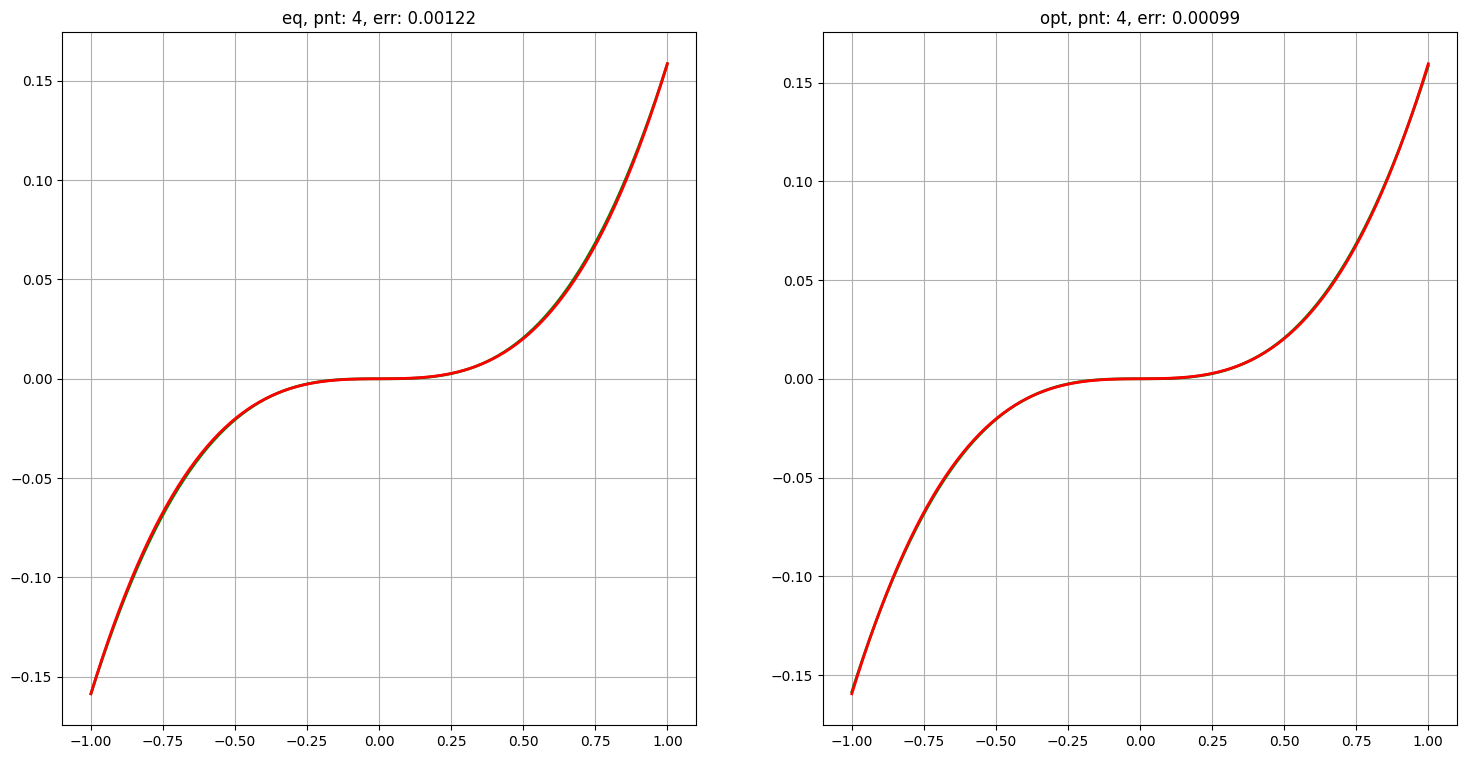

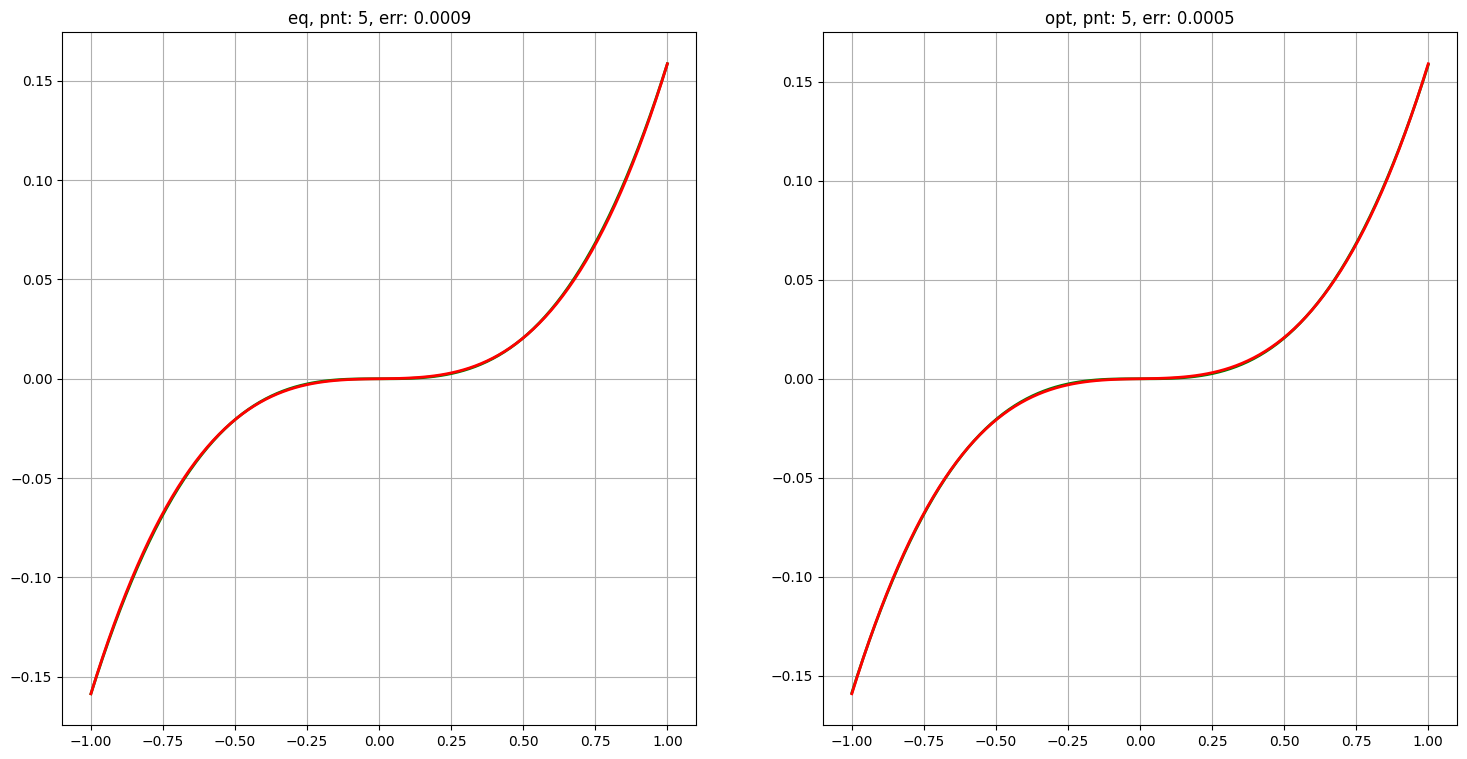

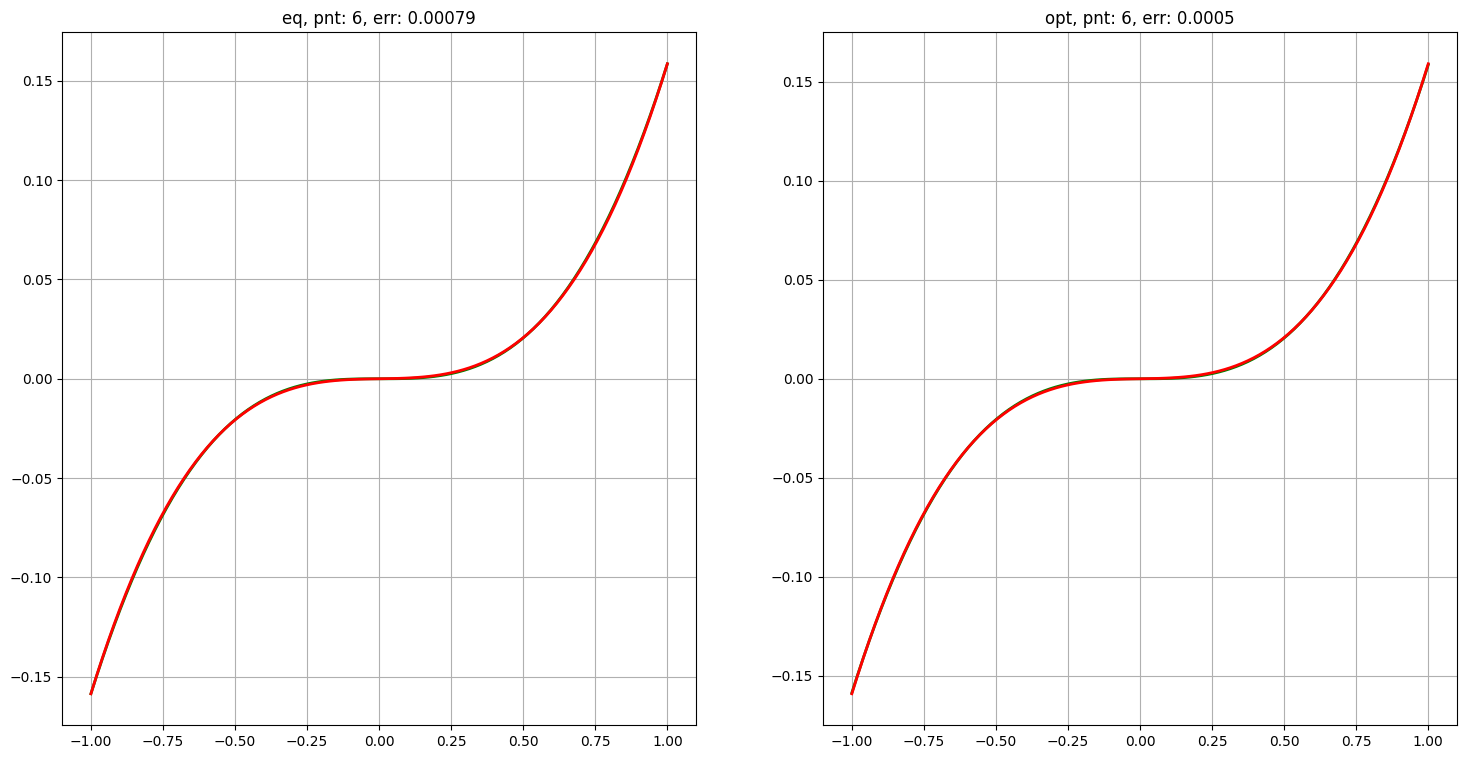

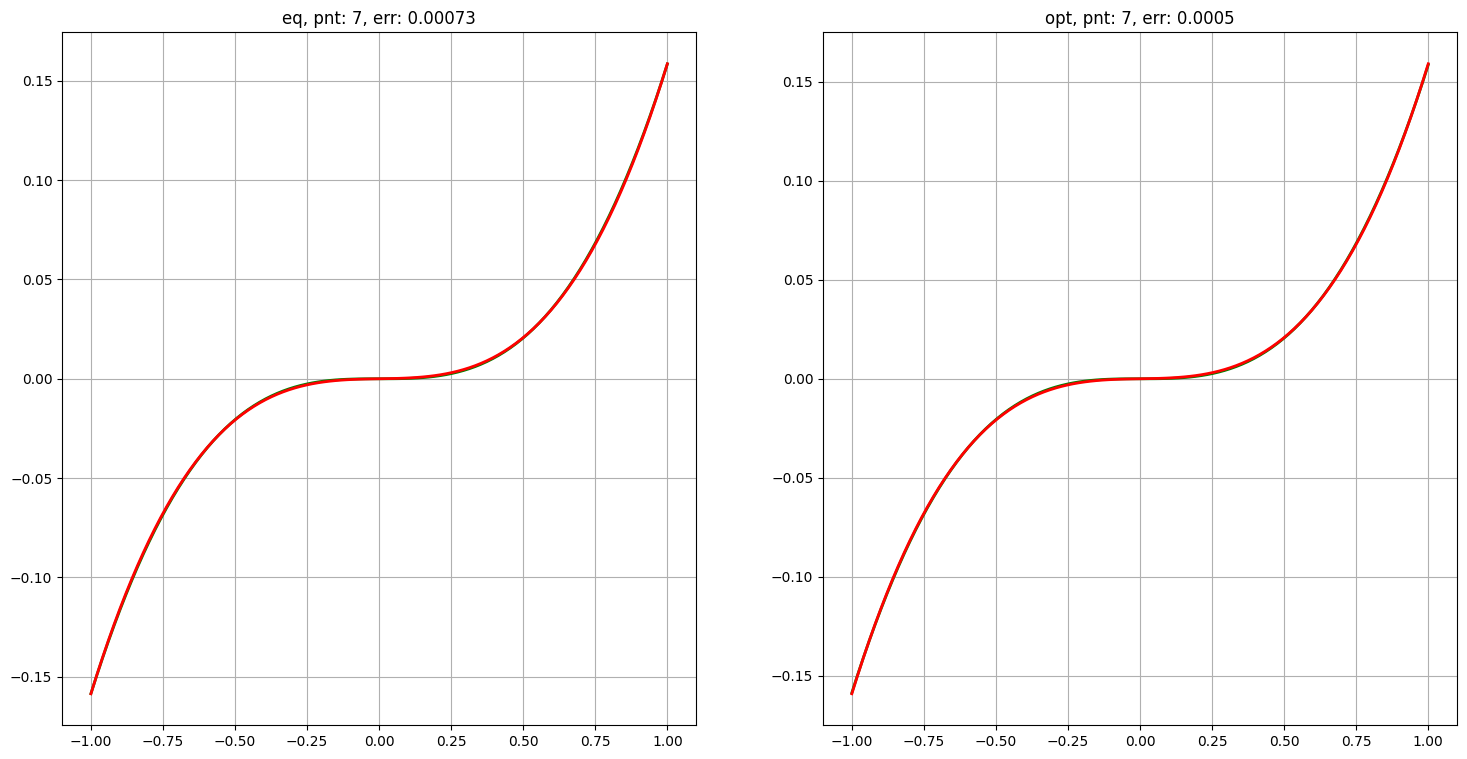

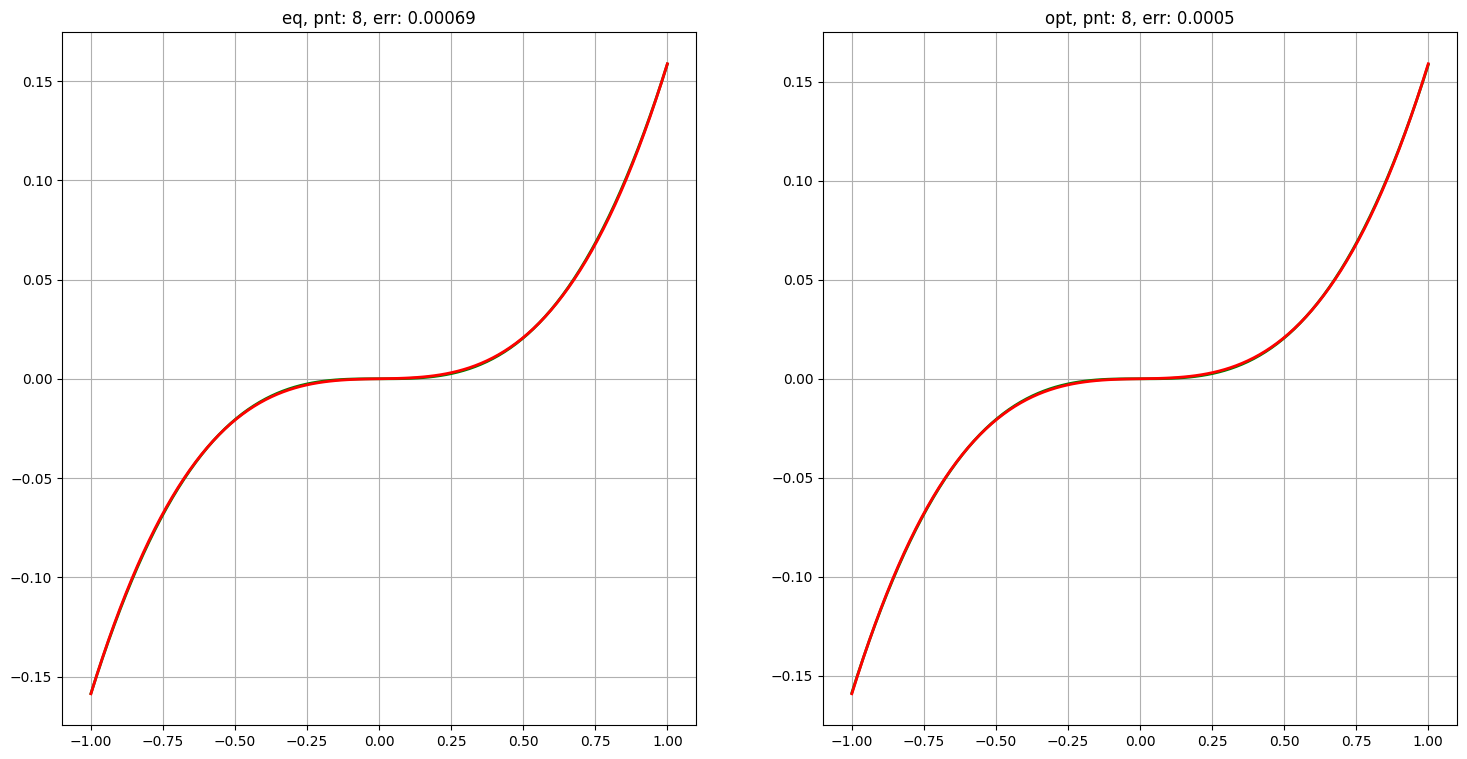

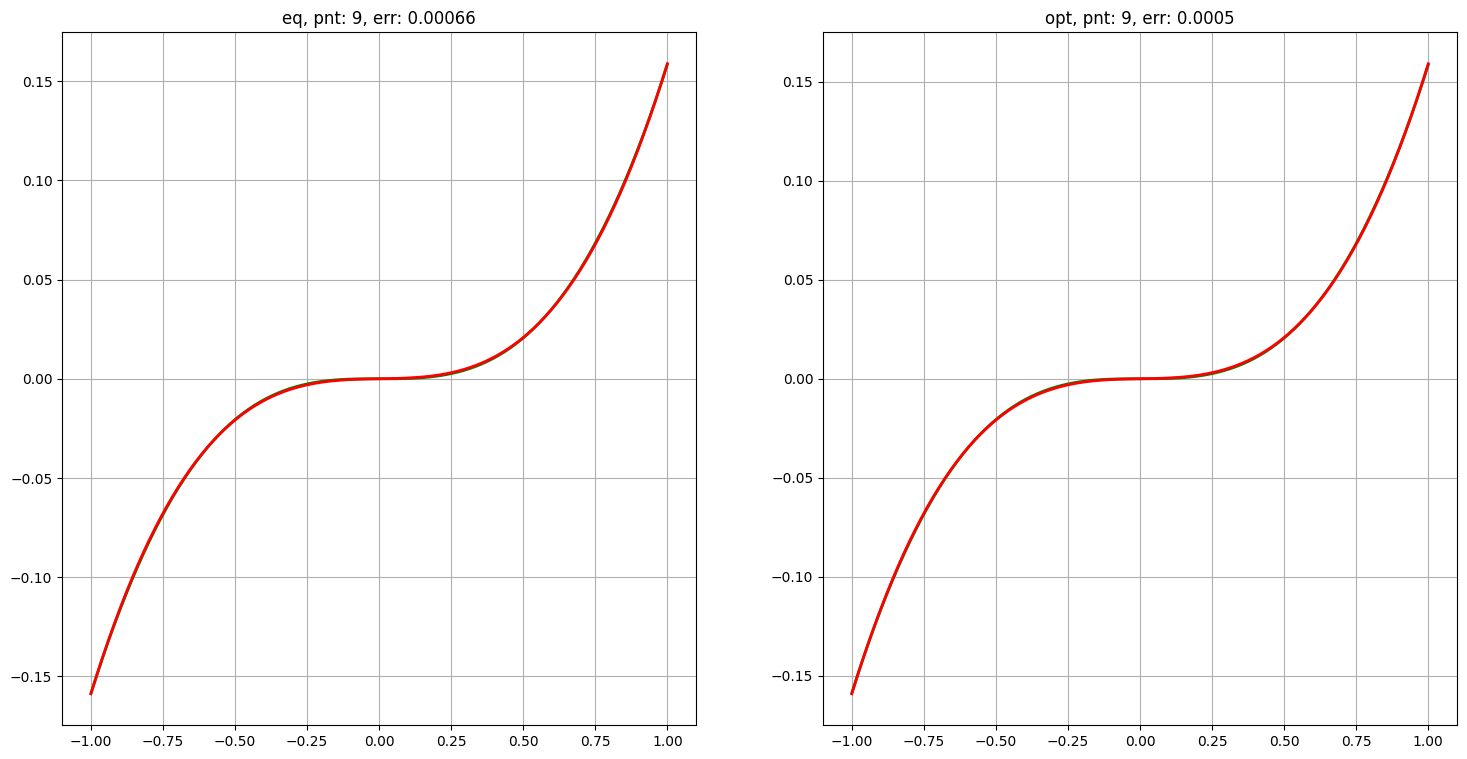

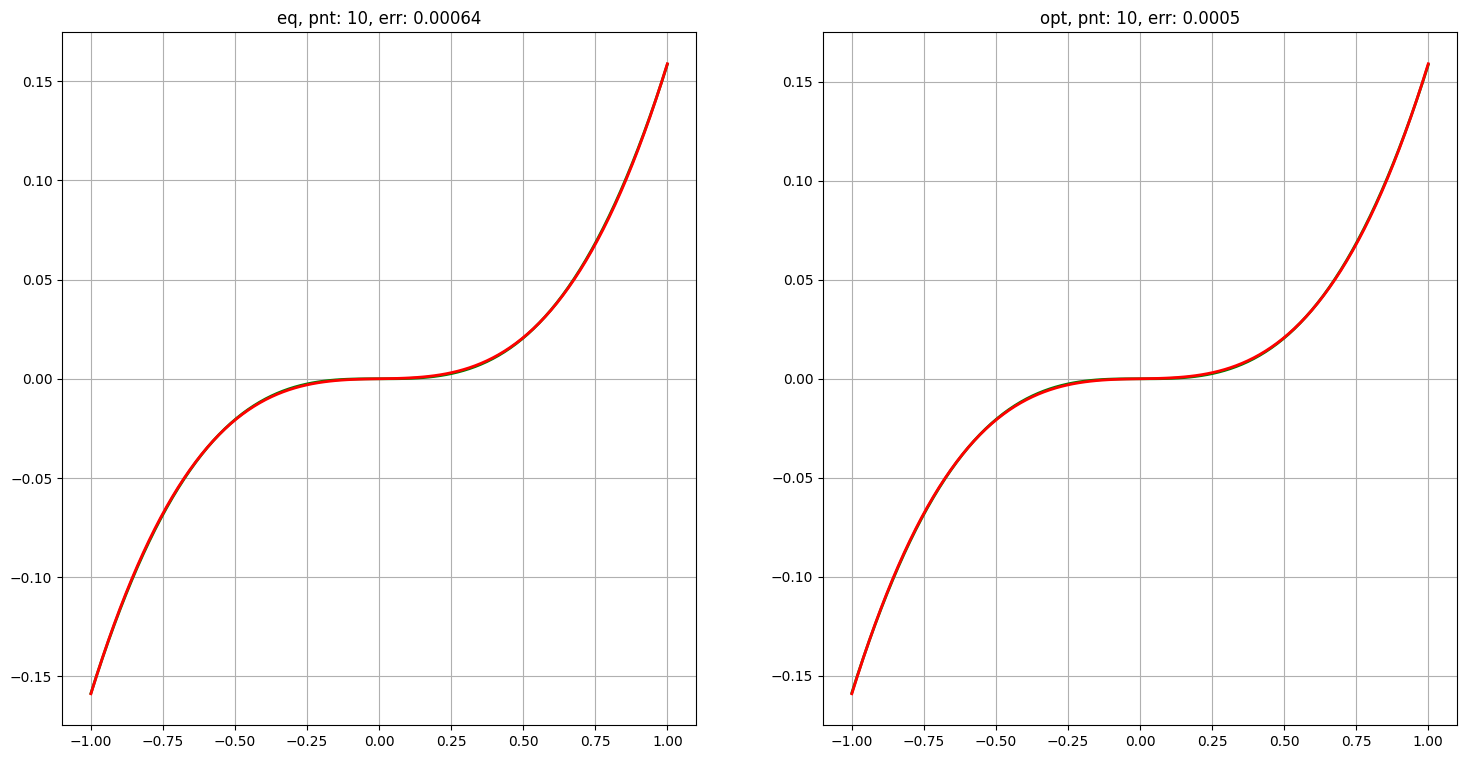

In [175]:
test_func = functions[0]
test_a = -1
test_b = 1
test_start_n = 4
test_end_n = 10
test_plot_n = 100
print('First test:')
test(test_func, test_a, test_b, test_start_n, test_end_n, test_plot_n)